# Assignment 05

## Robert Knox

In [2]:
#Imports needed for this notebook
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
#to make nice looking confusion matrices
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble.partial_dependence import plot_partial_dependence

## Data Processing

In [3]:
#NOTE: I manually deleted the row column
train = pd.read_csv("train_data.csv",sep=',',header='infer',index_col=None)
test = pd.read_csv("test_data.csv",sep=',',header='infer',index_col=None)

In [4]:
train.isna().any().any()

False

In [5]:
test.isna().any().any()

False

Files are clean for NA's. Assign out train & test.

In [6]:
X_train = train.iloc[:,1:train.columns.size]
y_train = train.iloc[:,0]
X_test = test.iloc[:,1:train.columns.size]
y_test = test.iloc[:,0]

In [7]:
y_train = np.reshape(y_train,len(y_train),1)

In [25]:
y_train.shape
X_train.shape

(507, 147)

In [9]:
#scale X's
scaler_train = StandardScaler(copy=False,with_mean=True, with_std=True)
scaler_train.fit(X_train)
X_train_scaled = scaler_train.transform(X_train)
X_test_scaled=scaler_train.transform(X_test)

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Bob\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Bob\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## Random Forest Classifier Base Model

In [18]:
basemodel = RandomForestClassifier()
basemodel.fit(X_train_scaled,y_train)
yhatbase = basemodel.predict(X_test_scaled)
yhatbase_probs = basemodel.predict_proba(X_test_scaled)

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion matrix, without normalization
[[14  0  0  0  0  0  0  0  0]
 [ 1 21  0  2  1  0  0  0  0]
 [ 0  2 13  0  0  0  0  0  0]
 [ 0  4  0 19  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  3]
 [ 1  1  1  0  0 12  0  0  0]
 [ 2  0  0  0  0  0 14  0  0]
 [ 0  2  0  4  2  0  0  6  0]
 [ 0  0  0  1  1  0  0  0 15]]


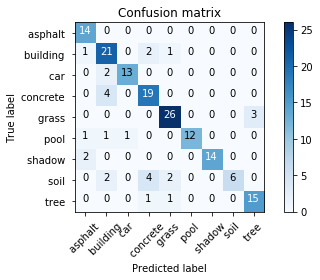

In [19]:
cm = confusion_matrix(y_test,yhatbase)
#helper function from http://scikit-learn.org/stable/
#auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes = np.sort(y_test.unique())
plot_confusion_matrix(cm,classes)

In [11]:
cr = classification_report(y_test,yhatbase)
print(cr)

              precision    recall  f1-score   support

    asphalt        0.74      1.00      0.85        14
   building        0.67      0.88      0.76        25
        car        0.91      0.67      0.77        15
   concrete        0.62      0.78      0.69        23
      grass        0.93      0.90      0.91        29
       pool        1.00      0.80      0.89        15
     shadow        1.00      0.88      0.93        16
       soil        1.00      0.29      0.44        14
       tree        0.83      0.88      0.86        17

   micro avg       0.80      0.80      0.80       168
   macro avg       0.86      0.79      0.79       168
weighted avg       0.84      0.80      0.80       168



In [12]:
#get the feature importance from the base model
feat_imp = basemodel.feature_importances_
c_names = X_train.columns

#function to help pull out the names from a dataframe in a sorted order
#feature_importance is a numpy array
#sorted_column_names is a list of column names in the same order as 
#feature_importance default
#returns a zip of column names & feature importance values sorted in order
def sorted_feature_importance(feature_importance,column_names):
    #turn that into an enumerated list so we know the index value of the importance
    list_feat_imp = list(enumerate(feature_importance))
    #sort our list in descending fashion
    list_feat_imp_sorted = sorted(list_feat_imp,key=lambda list_feat_imp:list_feat_imp[1],reverse=True)
    #do list comprehension to extract the value of the importance of the feature in
    feat_imp_sorted = [i[1] for i in list_feat_imp_sorted]
    #take the sorted list of features and extract their IDs
    sortednameids = [i[0] for i in list_feat_imp_sorted]
    #map the indices to the actual names from the dataframe
    sortednames = [column_names[i] for i in sortednameids]
    return zip(sortednameids,sortednames,feat_imp_sorted)

#use the helper function to get sorted features
srt_feats = sorted_feature_importance(feat_imp,c_names)
#unzip the values into lists for plotting
sorted_feat_ids,sorted_names,sorted_feat_vals = zip(*srt_feats)


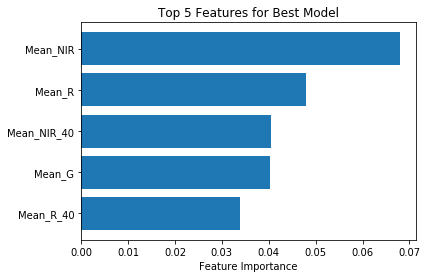

In [13]:
#needed to invert the lists for the bar chart to get the most 
#significant feature at the top
plt.barh(sorted_names[4::-1], sorted_feat_vals[4::-1])
plt.xlabel('Feature Importance')
plt.title('Top 5 Features for Best Model')
plt.show()

The top feature accounts for less than 7% of the model. This is better than at random since 1/147 = 0.68%.

## LinearSVM Classifier - Base Model:

In [14]:
basemodellinearsvc = LinearSVC()
basemodellinearsvc.fit(X_train_scaled,y_train)
yhatbaselinearsvc = basemodellinearsvc.predict(X_test_scaled)


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


default settings produce a convergence warning

In [15]:
cmbaselinearsvc = confusion_matrix(y_test,yhatbaselinearsvc)

Confusion matrix, without normalization
[[13  0  0  0  0  0  1  0  0]
 [ 0 22  1  1  1  0  0  0  0]
 [ 0  2 12  0  0  0  0  0  1]
 [ 1  6  0 15  0  0  0  0  1]
 [ 0  0  0  1 26  0  0  0  2]
 [ 1  0  1  0  0 13  0  0  0]
 [ 2  0  0  0  0  0 14  0  0]
 [ 0  4  0  1  3  0  0  6  0]
 [ 0  0  0  1  6  0  0  0 10]]


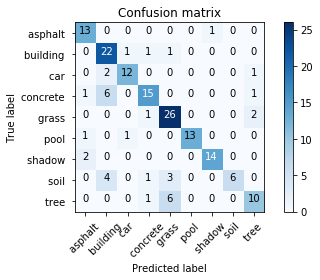

In [16]:
plot_confusion_matrix(cmbaselinearsvc,classes)

In [17]:
crbaselinearsvc = classification_report(y_test,yhatbaselinearsvc)
print(crbaselinearsvc)

              precision    recall  f1-score   support

    asphalt        0.76      0.93      0.84        14
   building        0.65      0.88      0.75        25
        car        0.86      0.80      0.83        15
   concrete        0.79      0.65      0.71        23
      grass        0.72      0.90      0.80        29
       pool        1.00      0.87      0.93        15
     shadow        0.93      0.88      0.90        16
       soil        1.00      0.43      0.60        14
       tree        0.71      0.59      0.65        17

   micro avg       0.78      0.78      0.78       168
   macro avg       0.83      0.77      0.78       168
weighted avg       0.80      0.78      0.77       168



There is no improvement in using the base linear svc.

## Support Vector Machine Classifier + Linear Kernel + Grid Search:

In [10]:
SVMC_LK = SVC( kernel = "linear")
#set up the grid search parameters
param_grid = {'C':np.arange(0.01,10,0.2)}

In [11]:

SVMC_LK_Grid = GridSearchCV(SVMC_LK, param_grid, cv = 5,
                       refit = True, n_jobs=-1, verbose = 0)

In [12]:
from timeit import default_timer as timer

start = timer()

SVMC_LK_Grid.fit(X_train_scaled,y_train)
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

7.145125696591492


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
SVMC_LK_bestparams = SVMC_LK_Grid.best_params_
SVMC_LK_bestparams

{'C': 0.01}

In [14]:
SVMC_LK_best_model = SVMC_LK_Grid.best_estimator_

In [15]:
yhat_SVMC_LK = SVMC_LK_best_model.predict(X_test_scaled)

In [16]:
cm_SVMC_LK_best_model = confusion_matrix(y_test,yhat_SVMC_LK)

Confusion matrix, without normalization
[[13  0  0  0  0  0  1  0  0]
 [ 0 22  0  2  1  0  0  0  0]
 [ 0  1 14  0  0  0  0  0  0]
 [ 0  5  0 17  0  0  0  1  0]
 [ 0  0  0  1 25  0  0  0  3]
 [ 0  0  0  0  0 14  1  0  0]
 [ 1  0  0  0  0  0 15  0  0]
 [ 0  3  0  5  2  0  0  4  0]
 [ 0  0  0  1  2  0  0  0 14]]


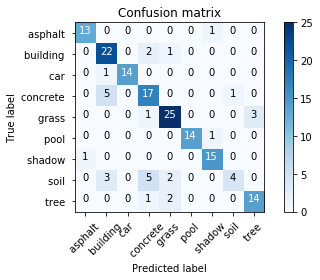

In [20]:
plot_confusion_matrix(cm_SVMC_LK_best_model,classes)

In [21]:
cr_SVMC_LK_best_model = classification_report(y_test,yhat_SVMC_LK)
print(cr_SVMC_LK_best_model)

              precision    recall  f1-score   support

    asphalt        0.93      0.93      0.93        14
   building        0.71      0.88      0.79        25
        car        1.00      0.93      0.97        15
   concrete        0.65      0.74      0.69        23
      grass        0.83      0.86      0.85        29
       pool        1.00      0.93      0.97        15
     shadow        0.88      0.94      0.91        16
       soil        0.80      0.29      0.42        14
       tree        0.82      0.82      0.82        17

   micro avg       0.82      0.82      0.82       168
   macro avg       0.85      0.81      0.82       168
weighted avg       0.83      0.82      0.81       168



## Support Vector Machine Classifier + Polynomial Kernel + Grid Search

5. Support Vector Machine Classifier + Polynomial Kernel + Grid Search:

We will now use GridSearchCV to try various hyperparameters in a SVM with a polynomial kernel.

a) Use SVC from sklearn with kernel = "poly". Run the GridSearchCV using the following:

C: 0.01 - 10 in increments of 0.2
degree: 2, 3, 4, 5, 6

Note: Feel free to try out more parameters, the above is the bare minimum for this assignment.

Use 5 cross-fold and the default scoring.

b) Identify the best performing model:

.best_params_() : This method outputs to best performing parameters
.best_estimator_() : This method outputs the best performing model, and can be used for predicting on the X_test

c) Use the best estimator model to predict on test data. Use the .predict() method to get the predicted classes.

d) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

In [29]:
SVMC_PK = SVC( kernel = "poly")
#set up the grid search parameters
param_grid_pk = {'C':np.arange(0.01,10,0.2),
             'degree':np.arange(2,10,1)}


In [30]:
SVMC_PK_Grid = GridSearchCV(SVMC_PK, param_grid_pk, cv = 5,
                       refit = True, n_jobs=-1, verbose = 0)

In [31]:
start = timer()

SVMC_PK_Grid.fit(X_train_scaled,y_train)
end = timer()
print(end - start)

57.16381248187656


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [33]:
SVMC_PK_bestparams = SVMC_PK_Grid.best_params_
SVMC_PK_bestparams

{'C': 8.41, 'degree': 3}

In [34]:
SVMC_PK_best_model = SVMC_PK_Grid.best_estimator_

In [36]:
yhat_SVMC_PK = SVMC_PK_best_model.predict(X_test_scaled)

In [37]:
cm_SVMC_PK_best_model = confusion_matrix(y_test,yhat_SVMC_PK)

Confusion matrix, without normalization
[[13  0  0  0  0  0  1  0  0]
 [ 0 22  0  2  1  0  0  0  0]
 [ 0  2 11  0  0  1  0  1  0]
 [ 0  5  0 17  0  0  0  1  0]
 [ 0  0  0  0 26  0  0  1  2]
 [ 0  0  0  0  0 14  1  0  0]
 [ 2  0  0  0  0  0 14  0  0]
 [ 0  3  0  4  6  0  0  1  0]
 [ 0  0  0  1  3  0  0  0 13]]


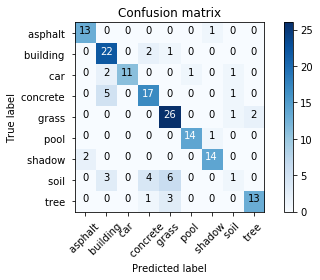

In [38]:
plot_confusion_matrix(cm_SVMC_PK_best_model,classes)

In [39]:
cr_SVMC_PK_best_model = classification_report(y_test,yhat_SVMC_PK)
print(cr_SVMC_PK_best_model)

              precision    recall  f1-score   support

    asphalt        0.87      0.93      0.90        14
   building        0.69      0.88      0.77        25
        car        1.00      0.73      0.85        15
   concrete        0.71      0.74      0.72        23
      grass        0.72      0.90      0.80        29
       pool        0.93      0.93      0.93        15
     shadow        0.88      0.88      0.88        16
       soil        0.25      0.07      0.11        14
       tree        0.87      0.76      0.81        17

   micro avg       0.78      0.78      0.78       168
   macro avg       0.77      0.76      0.75       168
weighted avg       0.76      0.78      0.76       168



## Support Vector Machine Classifier + RBF Kernel + Grid Search

In [34]:
SVMC_RBFK = SVC( kernel = "rbf")
#set up the grid search parameters
param_grid_rbfk = {'C':np.arange(0.01,10,0.2),
             'gamma':[0.001,0.01,0.1,1,10,100]}


In [35]:
SVMC_RBFK_Grid = GridSearchCV(SVMC_RBFK, param_grid_rbfk, cv = 5,
                       refit = True, n_jobs=-1, verbose = 0)

In [36]:
start = timer()

SVMC_RBFK_Grid.fit(X_train_scaled,y_train)
end = timer()
print(end - start)

60.925614734831015


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [37]:
SVMC_RBFK_bestparams = SVMC_RBFK_Grid.best_params_
SVMC_RBFK_bestparams

{'C': 4.21, 'gamma': 0.01}

In [38]:
SVMC_RBFK_best_model = SVMC_RBFK_Grid.best_estimator_

In [39]:
yhat_SVMC_RBFK = SVMC_RBFK_best_model.predict(X_test_scaled)

In [40]:
cm_SVMC_RBFK_best_model = confusion_matrix(y_test,yhat_SVMC_RBFK)

Confusion matrix, without normalization
[[13  0  0  0  0  0  1  0  0]
 [ 0 21  0  3  1  0  0  0  0]
 [ 0  1 13  1  0  0  0  0  0]
 [ 0  4  0 19  0  0  0  0  0]
 [ 0  1  0  0 26  0  0  0  2]
 [ 0  0  0  0  0 14  1  0  0]
 [ 1  0  0  0  0  0 15  0  0]
 [ 0  2  0  4  3  0  0  5  0]
 [ 0  0  0  1  1  0  0  0 15]]


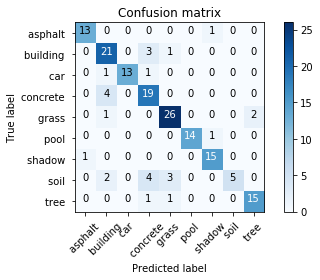

In [41]:
plot_confusion_matrix(cm_SVMC_RBFK_best_model,classes)

In [42]:
cr_SVMC_RBFK_best_model = classification_report(y_test,yhat_SVMC_RBFK)
print(cr_SVMC_RBFK_best_model)

              precision    recall  f1-score   support

    asphalt        0.93      0.93      0.93        14
   building        0.72      0.84      0.78        25
        car        1.00      0.87      0.93        15
   concrete        0.68      0.83      0.75        23
      grass        0.84      0.90      0.87        29
       pool        1.00      0.93      0.97        15
     shadow        0.88      0.94      0.91        16
       soil        1.00      0.36      0.53        14
       tree        0.88      0.88      0.88        17

   micro avg       0.84      0.84      0.84       168
   macro avg       0.88      0.83      0.84       168
weighted avg       0.86      0.84      0.83       168



## Which performs the best based on the Classification Report?

The best performing model was the support vector machine with the rbf kernel that executed grid search. It had the highest  f-scores for all calculation methodologies (micro, macro & weighted averages).

|Model                           |micro |macro |weighted|
|--------------------------------|------|------|--------|
| Random Forest                  | 0.80 | 0.79 | 0.80 |
| LinearSVM                      | 0.78 | 0.77 | 0.77 |
| Linear Kernel + GridSearch |0.82|0.82|0.81|
| Polynomial Kernel + GridSearch | 0.78 | 0.75 | 0.76 |
| **RBF Kernel + GridSearch**        | **0.84** | **0.84** | **0.83** |


## What is the benefit of using a polynomial or rbf kernel over a linear kernel?

Polynomial and rbf kernels allow you to build models that do not rely on a linear relationship between the predictors and the output. 

## What could be a downside of using a polynomial or rbf kernel?

The downside to a polynomial or rbf kernel is the potential for overfitting the data. In addition, applying those kernels reduces the interpretability of the model. Finally, there is the additional calculation performed in the kernel itself which increases the computation time.

## Explain the 'C' parameter used in steps 4-6.

The C parameter is a regularization term that allows you to adjust the extent of the soft margin classification. Higher values of C lead to fewer margin violations. It makes the svm more restrictive. Lower values of C lead to more margin violations. It makes the svm less restrictive.

## Why is it important to use the 'C' parameter when fitting a model?

It is important to use the C parameter because it allows us to control the bias of the model. Setting a high value of C increases the models bias  whereas a low value of C reduces it.

## For your best performing model provide metrics for the training and test sets and explain whether your model is overfitting the data. 


In [43]:
#build our predictions using our training set
yhat_train_SVMC_RBFK = SVMC_RBFK_best_model.predict(X_train_scaled)
#build a classification report from the 
cr_SVMC_RBFK_best_model_train = classification_report(y_train,yhat_train_SVMC_RBFK)
print(cr_SVMC_RBFK_best_model_train)

              precision    recall  f1-score   support

    asphalt        1.00      1.00      1.00        45
   building        0.98      1.00      0.99        97
        car        1.00      1.00      1.00        21
   concrete        1.00      0.99      0.99        93
      grass        0.99      0.99      0.99        83
       pool        1.00      1.00      1.00        14
     shadow        1.00      1.00      1.00        45
       soil        1.00      1.00      1.00        20
       tree        1.00      0.99      0.99        89

   micro avg       0.99      0.99      0.99       507
   macro avg       1.00      1.00      1.00       507
weighted avg       0.99      0.99      0.99       507



The model is almost perfect at predicting the training data set. This points to overfitting. Selecting another model with a lower f1-score in training while maintaining  a good f1-score with test data would be preferred.